<p style="font-family: 'Georgia', serif; font-size: 20px; font-weight: bold; text-align: center; color: #000305; background-color: #5bf0c8; padding: 20px; border: 2px solid #D4EBF8; border-radius: 15px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">When deep learning meets symbolic AI: </p>

<p style="font-family: 'Georgia', serif; font-size: 40px; font-weight: bold; text-align: center; color: #000305; background-color: #5bf0c8; padding: 20px; border: 2px solid #D4EBF8; border-radius: 15px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">Industrial Equipment Monitoring with AI and ontologies 🦾 </p>




In this notebook I am going to demonstrate how ontologies as world models can enhance ML/DL workflows.

🗺️ All comments about ontologies and symbolic AI will be marked with the "world map" emoji 🗺️ (as I firmly believe in ontologies as world models which help humans and machines to navigate through organisational complexity)

_As foundation for this work I took the notebook by [Dinesh Naveen Kumar Samudrala](https://www.kaggle.com/dnkumars), which he published on Kaggle, adjusted it for my needs, added more checks and algorithms, and added all about the ontologies._

# Preparation steps

<div align="center" style="background-color: #fcba03; padding: 20px; border-radius: 10px;">
  <h1 style="color: #050400;">Loading Libraries</h1>
</div>

## Loading libraries

In [37]:
# foundational data libraries
import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from IPython.display import IFrame

# ML & DL libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input

In [39]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

<div align="center" style="background-color: #77CDFF; padding: 20px; border-radius: 10px;">
  <h1 style="color: D9EAFD5;">Load and Check the Data</h1>
</div>v>

# Load and check the data

🗺️ Kaggle provides data usability metrics. The same can be implemented internally in any organisation that needs to scale. Data needs to follow to the FAIR principles (findability, accessibility, interoperability, and reusability) to deliver value. Ontologies can play a role in it as an annotation helper (more on that - below). But also you can use in order to transform and improve the quality of your datasets before publishing them as a Data Product (data that conforms to the aforementioned FAIR principles).

An interesting use case would be to enrich existing data with additional attributes which are not contained within the dataset, but are captured in an ontology. Reasoning engines can further help by deriving new data from the implicit state into an explicit one.

In [3]:
data = pd.read_csv("/kaggle/input/industrial-equipment-monitoring-dataset/equipment_anomaly_data.csv")

In [4]:
data.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


In [5]:
data.isnull().sum()  # per column

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [ ]:
data.isna().sum()  # per column

In [ ]:
data.duplicated().sum()  # rows

In [19]:
data.columns.tolist()  # visual check (e.g. for whitespaces)

['temperature',
 'pressure',
 'vibration',
 'humidity',
 'equipment',
 'location',
 'faulty',
 'city',
 'latitude',
 'longitude']

In [6]:
data['equipment'].value_counts()

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [ ]:
data["faulty"] = data["faulty"].astype(int)

🗺️ We can see that the "equipment" columns contains information about industrial machines whose behaviour is captured in this data. Current dataset contains 3 types of equipment: compressor, turbine, pump.

First of all, these names can mean different things in different industries. Second, let's imagine that the dataset would be more granular and contain subtypes or specific models of the equipment. Let's say, a heat pump, "Monoblock Heat Pump 8kW". And the company producing those heat pumps wants to **develop multiple algorithmic models for the same product** - e.g. one for the predictive maintenance, and another one for a real-time simulation of a large building, and yet another one serving as a visual representation for this specific heat pump to modify its design. Each of those models would require different kinds of data, probably stored in different data storages.

To make sure that all those datasets and models speak the same language, we need to somehow map them all to the single source of truth. Which can be an ontology.

<div align="center" style="background-color: #17ffd1; padding: 20px; border-radius: 10px;">
  <h1 style="color:#0504008;">Exploratory Data Analysis</h1>

</div>

# Exploratory data analysis

## Univariate Analysis

In [9]:
fig1 = px.histogram(data, x="temperature", title="Temperature Distribution")
filename="hist1.html"
plot(fig1, filename=filename, auto_open=False)
display(IFrame(filename, width=800, height=600))

<Axes: xlabel='equipment', ylabel='count'>

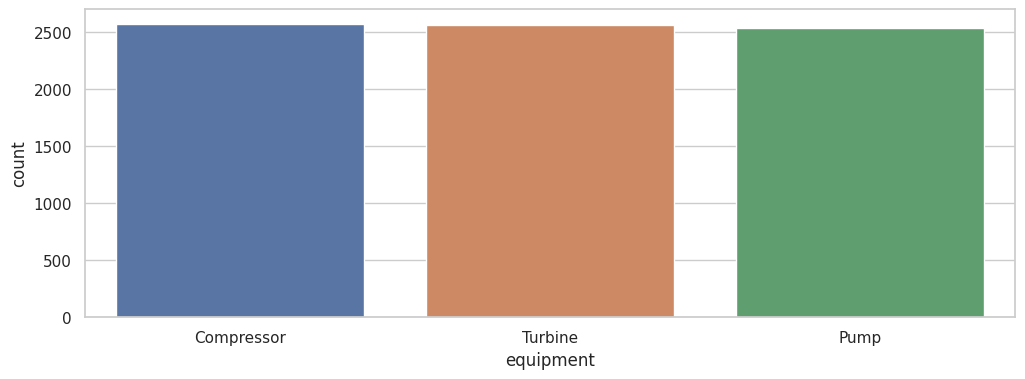

In [10]:
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")
sns.countplot(data=data, x='equipment', order=data['equipment'].value_counts().index)

<Axes: xlabel='faulty', ylabel='count'>

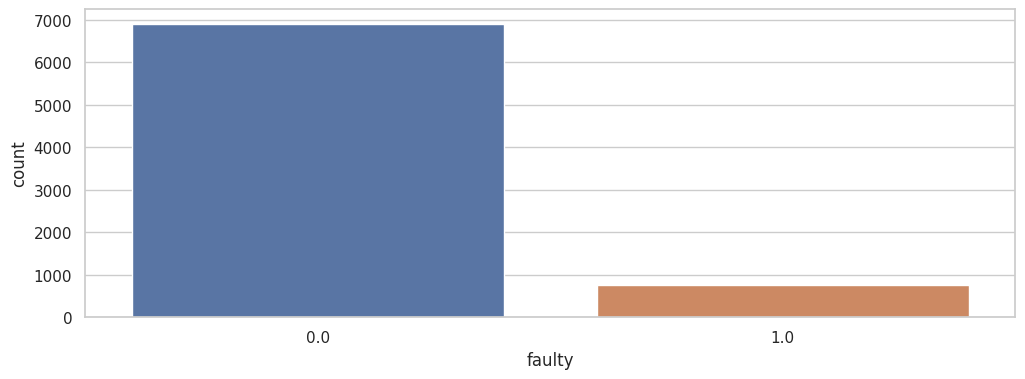

In [8]:
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")
sns.countplot(data=data, x='faulty', order=data['faulty'].value_counts().index)

In [11]:
fig2 = px.box(data, y='humidity',color='equipment', title="Humidity Distribution")
filename="box.html"
plot(fig2, filename=filename, auto_open=False)
display(IFrame(filename, width=800, height=600))

## Bivariate Analysis

In [12]:
fig3 = px.scatter(data, x="temperature", y="pressure", color="faulty", title="Temperature vs Pressure")
filename="scatter1.html"
plot(fig3, filename=filename, auto_open=False)
display(IFrame(filename, width=800, height=600))

<Axes: >

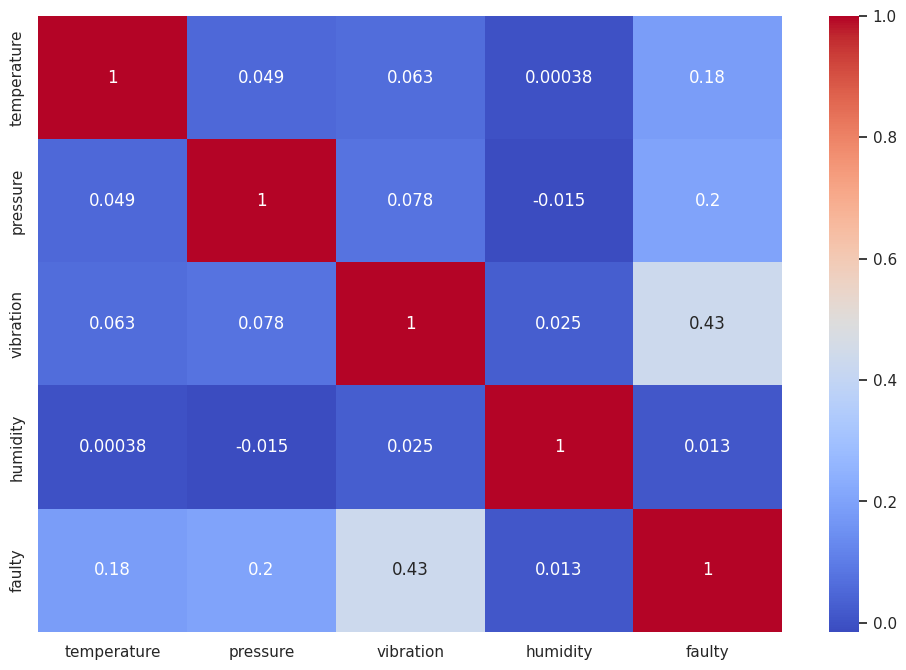

In [30]:
corr_matrix = data.drop(['equipment','location'],axis=1).corr()
# corr_matrix = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

array([[<Axes: xlabel='temperature', ylabel='temperature'>,
        <Axes: xlabel='pressure', ylabel='temperature'>,
        <Axes: xlabel='vibration', ylabel='temperature'>,
        <Axes: xlabel='humidity', ylabel='temperature'>,
        <Axes: xlabel='faulty', ylabel='temperature'>],
       [<Axes: xlabel='temperature', ylabel='pressure'>,
        <Axes: xlabel='pressure', ylabel='pressure'>,
        <Axes: xlabel='vibration', ylabel='pressure'>,
        <Axes: xlabel='humidity', ylabel='pressure'>,
        <Axes: xlabel='faulty', ylabel='pressure'>],
       [<Axes: xlabel='temperature', ylabel='vibration'>,
        <Axes: xlabel='pressure', ylabel='vibration'>,
        <Axes: xlabel='vibration', ylabel='vibration'>,
        <Axes: xlabel='humidity', ylabel='vibration'>,
        <Axes: xlabel='faulty', ylabel='vibration'>],
       [<Axes: xlabel='temperature', ylabel='humidity'>,
        <Axes: xlabel='pressure', ylabel='humidity'>,
        <Axes: xlabel='vibration', ylabel='humidit

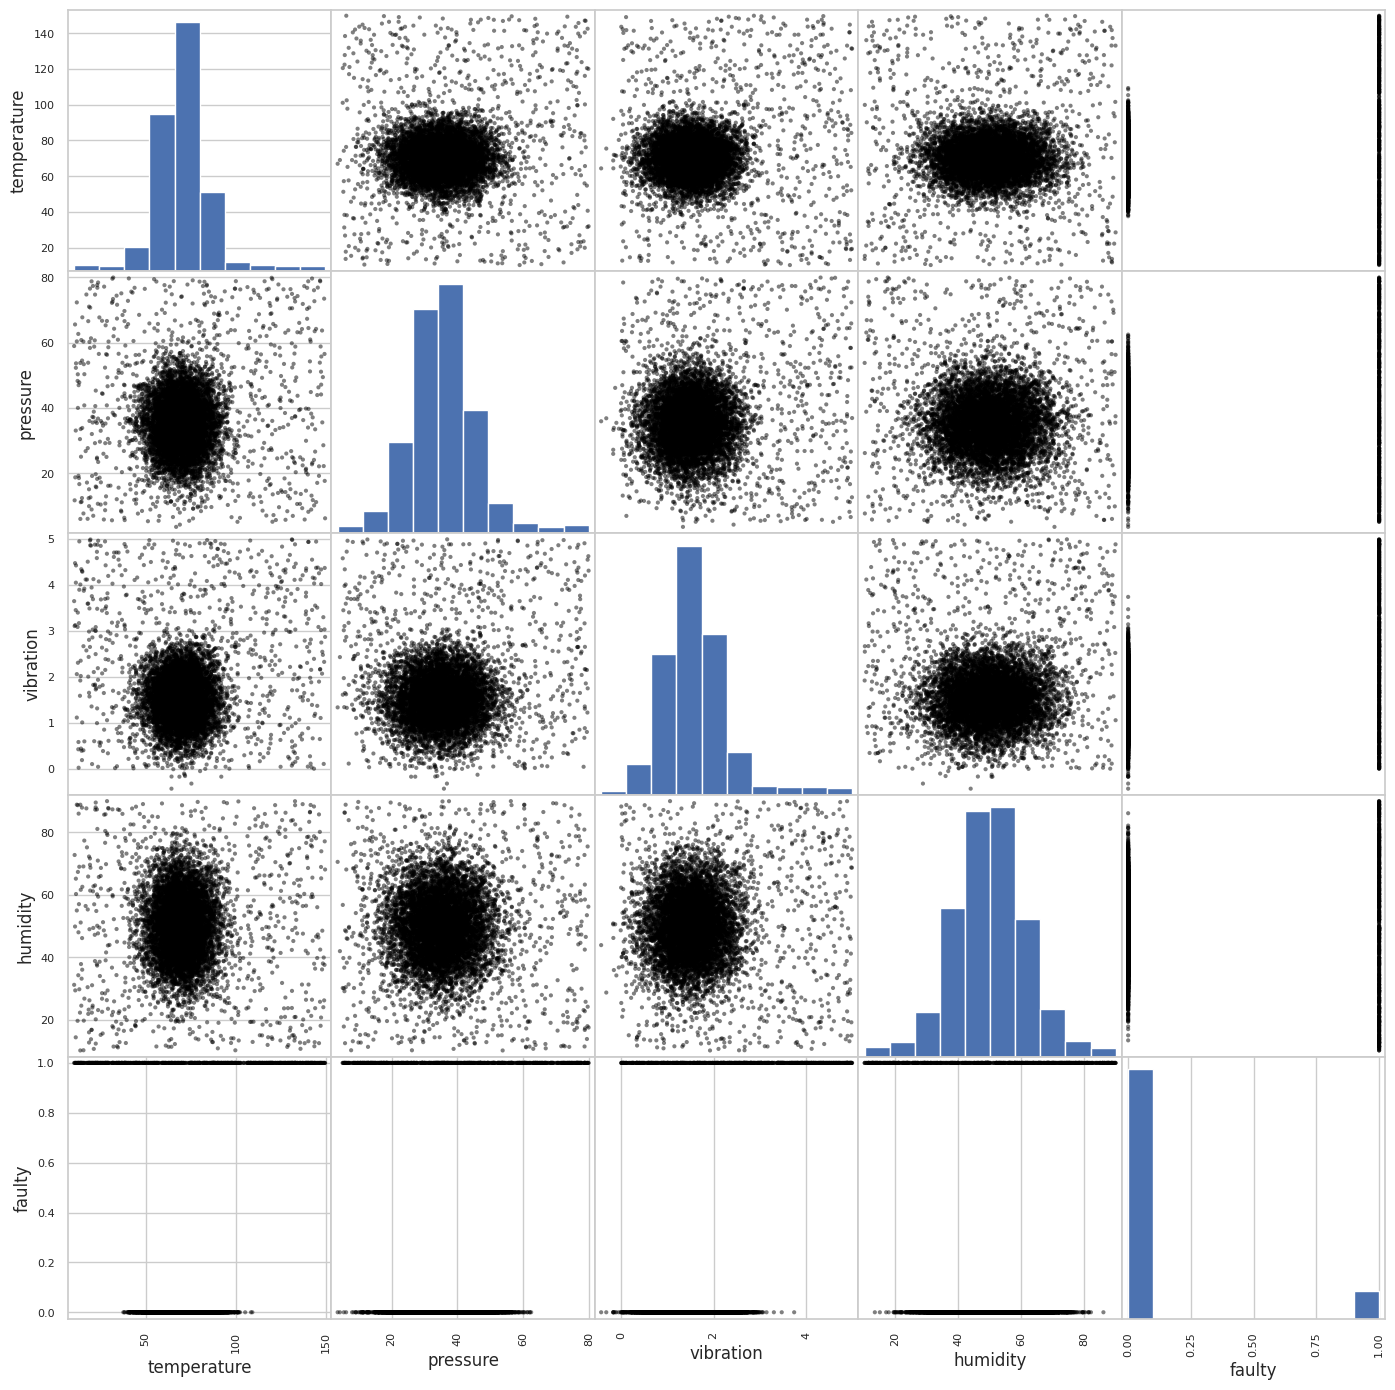

In [32]:
# Let's explore our dataset in a different way and plot every feature against all the others 
# pay special attention to the relationship between each feature and the target feature.

from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize=(17,17),color='black')

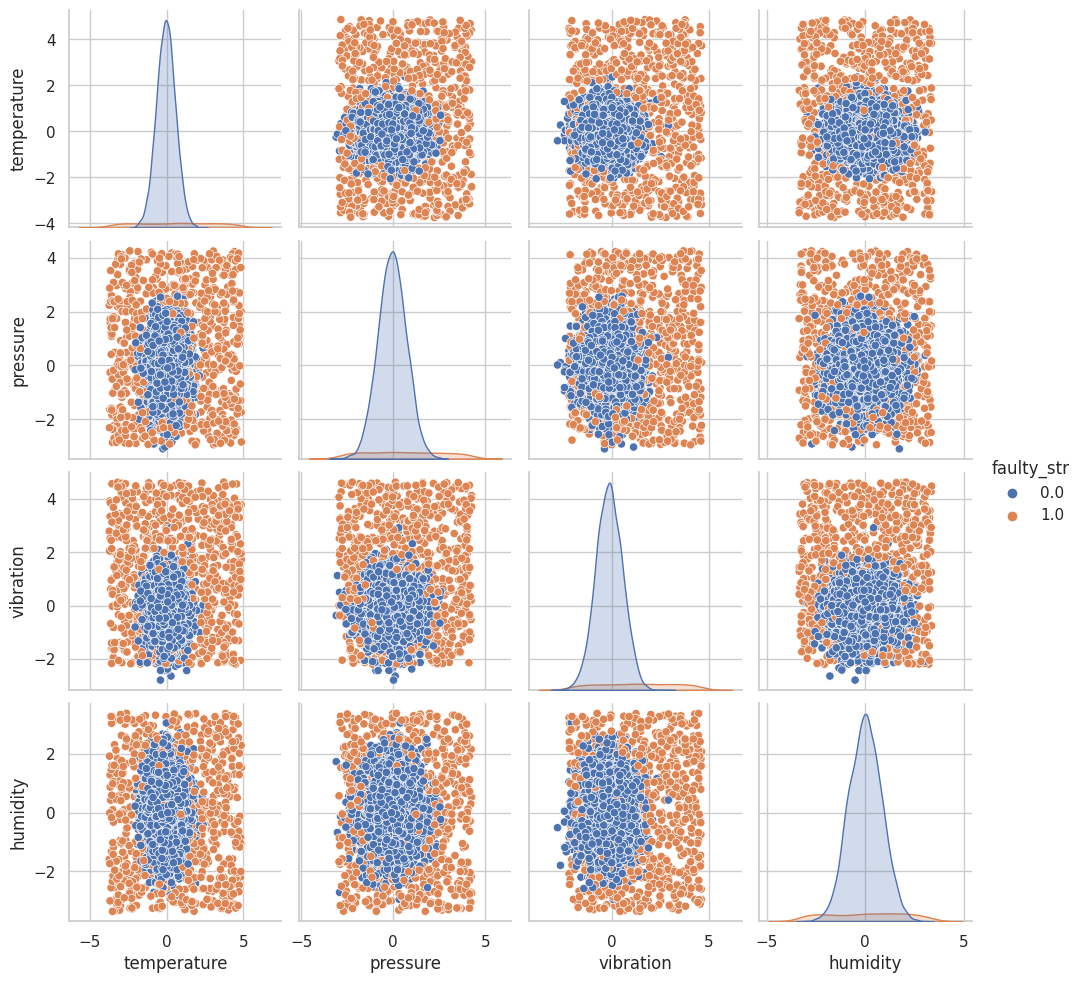

In [40]:
# Alternative approach

data["faulty_str"] = data["faulty"].astype(str)

sns.pairplot(
    data=data.assign(faulty_str=data["faulty"].astype(str)),
    vars=['temperature', 'pressure', 'vibration','humidity'],
    hue="faulty_str"
)
plt.show()

<div align="center" style="background-color: #FFE3E3; padding: 20px; border-radius: 10px;">
  <h1 style="color: #091057;">Data Preprocessing</h1>

</div>

In [10]:
# Convert text-based categories into numerical ones
label_encoder = LabelEncoder()
data['equipment'] = label_encoder.fit_transform(data['equipment'])
data['location'] = label_encoder.fit_transform(data['location'])

In [11]:
data.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,2,0,0.0
1,75.740712,22.954018,2.338095,41.867407,0,1,0.0
2,71.358594,27.276830,1.389198,58.954409,2,4,0.0
3,71.616985,32.242921,1.770690,40.565138,1,0,0.0
4,66.506832,45.197471,0.345398,43.253795,1,3,0.0


In [12]:
scaler = StandardScaler()
numerical_cols = ['temperature', 'pressure', 'vibration', 'humidity']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [13]:
data.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,-0.786610,-1.031582,-1.379925,-0.364984,2,0,0.0
1,0.297440,-1.231493,0.996943,-0.688233,0,1,0.0
2,0.026922,-0.815074,-0.305569,0.754840,2,4,0.0
3,0.042873,-0.336688,0.218089,-0.798215,1,0,0.0
4,-0.272588,0.911232,-1.738352,-0.571147,1,3,0.0


## Further ideas
❗ Feature engineering: think whether new features are needed

❗Think about possibility to use SMOTE (Synthetic Minority Over-sampling Technique): method for handling imbalanced datasets in ML. 
Works as simple as:

```python
from imblearn.over_sampling import SMOTE  # library for imbalanced learning

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

```


<div align="center" style="background-color: #FFD7C4; padding: 20px; border-radius: 10px;">
  <h1 style="color: #001F3F;">Modeling</h1>

</div>iv>

# Modeling

<div align="center" style="background-color: #34ebc6; padding: 20px; border-radius: 10px;">
  <h1 style="color: #001F3F;">Let's start with Random Forest to a create baseline</h1>

</div>

## Random Forest

In [15]:
X = data.drop(columns=["faulty"])
y = data["faulty"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
RF = RandomForestClassifier(class_weight='balanced', random_state=42)
RF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [33]:
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1377
         1.0       0.94      0.86      0.90       158

    accuracy                           0.98      1535
   macro avg       0.96      0.93      0.94      1535
weighted avg       0.98      0.98      0.98      1535



In [26]:
accuracy_score(y_test,y_pred)  # accuracy is not bad in general, but no so great for faulty cases

0.9824104234527687

In [34]:
cm = confusion_matrix(y_test, y_pred)
fig5 = go.Figure(data=go.Heatmap(
    z=cm,
    x=["Predicted 0", "Predicted 1"],  
    y=["Actual 0", "Actual 1"],
    colorscale='Viridis',
    text=np.round(cm, 2),  
    hoverinfo="z"  
))
fig5.update_traces(
    texttemplate="%{text}",
    textfont={"size": 12},
    showscale=True 
)

fig5.update_layout(
    title="Confusion Matrix Heatmap",
    xaxis_title="Predicted Label",
    yaxis_title="True Label",
    autosize=True)
filename = "cm.html"
plot(fig5, filename=filename, auto_open=False)
IFrame(filename, width=800, height=600)

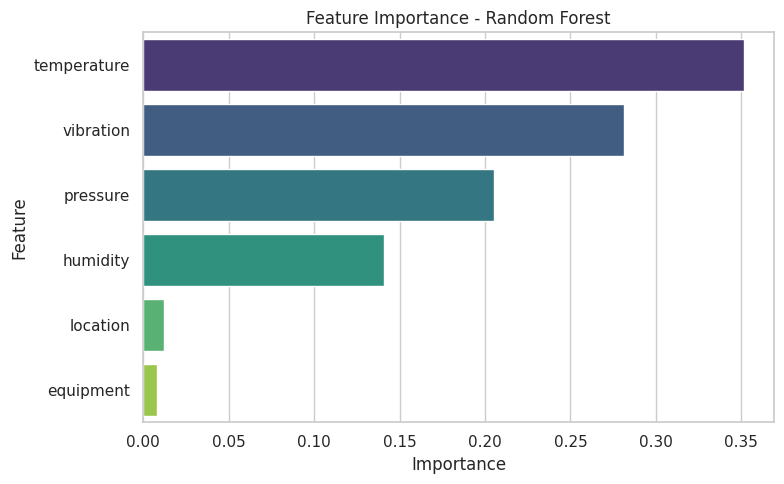

In [35]:
importances = RF.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

--------------------------------------------------

<div align="center" style="background-color: #327ba8; padding: 20px; border-radius: 10px;">
  <h1 style="color: #001F3F;">Further exploration using ML</h1>

</div>

## Further exploration using ML

### Clustering

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)
feature_x = 'temperature'
feature_y = 'pressure'
fig7 = px.scatter(
    X, 
    x=feature_x, 
    y=feature_y, 
    color=clusters.astype(str),  
    title=f"KMeans Clustering ({feature_x} vs {feature_y})",
    labels={feature_x: feature_x.capitalize(), feature_y: feature_y.capitalize()}
)
filename = "clust_no_pca.html"
plot(fig7, filename=filename, auto_open=False)
IFrame(filename, width=800, height=600)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Anomaly Detection

In [20]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data["anomaly"] = iso_forest.fit_predict(X)
fig8 = px.scatter(data, x="temperature", y="pressure", color="anomaly", title="Anomaly Detection")
filename="ano.html"
plot(fig8, filename=filename, auto_open=False)
display(IFrame(filename, width=800, height=600))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Anomaly detection didn't work too well.

<div align="center" style="background-color: #34ebc6; padding: 20px; border-radius: 10px;">
  <h1 style="color: #001F3F;">Finally: neural networks</h1>

</div>

## Neural network

In [21]:
"""
Architecture:

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

Dense:
- fully connected layers with 32, 16 and 1 neurons
- Each neuron receives input from all neurons in the previous layer.
- Activation introduces non-linearity, helping the network learn complex patterns.
- Sigmoid activation used because this is a binary classification problem
"""
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

"""
Training will adjust weights to minimize this loss.
- `binary_crossentropy` is an appropriate loss function for binary classification.
- `adam` as adaptive optimizer (popular, fast convergence, works well in many cases).
"""
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test)

Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8895 - loss: 0.4110 - val_accuracy: 0.9503 - val_loss: 0.2100
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9555 - loss: 0.1789 - val_accuracy: 0.9699 - val_loss: 0.1234
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9746 - loss: 0.1034 - val_accuracy: 0.9788 - val_loss: 0.0828
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9813 - loss: 0.0719 - val_accuracy: 0.9780 - val_loss: 0.0683
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0686 - val_accuracy: 0.9780 - val_loss: 0.0654
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0554 - val_accuracy: 0.9813 - val_loss: 0.0602
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9857 - loss: 0.0540 - val_accuracy: 0.9813 - val_loss: 0.0627
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0507 - val_accuracy: 0.

In [27]:
print(f"Test Accuracy: {accuracy}")  # comparable to the accuracy of the random forest

Test Accuracy: 0.9850162863731384


In [28]:
fig10 = go.Figure()
fig10.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig10.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig10.update_layout(title="Model Accuracy Over Epochs", xaxis_title="Epochs", yaxis_title="Accuracy")
filename="ann.html"
plot(fig10, filename=filename, auto_open=False)
display(IFrame(filename, width=800, height=600))

🗺️ We can see that the neural network and random forest showed comparable results. Thus let's imagine that both models were published internally and thus can be searched through some kind of catalog. If we stick to the shared vocabulary, expressed through e.g. an ontology, we can be sure that users will find both the datasets and the ML/DL models trained on them, as we annotate our data and models in a consistent way.